In [22]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline

# Regression Analysis: Seasonal Effects with Sklearn Linear Regression
In this notebook, you will build a SKLearn linear regression model to predict Yen futures ("settle") returns with *lagged* Yen futures returns. 

In [23]:
# Futures contract on the Yen-dollar exchange rate:
# This is the continuous chain of the futures contracts that are 1 month to expiration
yen_futures = pd.read_csv(
    Path("yen.csv"), index_col="Date", infer_datetime_format=True, parse_dates=True
)
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1976-08-02,3398.0,3401.0,3398.0,3401.0,NaN,3401.0,2.0,1.0
1976-08-03,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-04,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-05,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0
1976-08-06,3401.0,3401.0,3401.0,3401.0,NaN,3401.0,0.0,1.0


In [24]:
# Trim the dataset to begin on January 1st, 1990
yen_futures = yen_futures.loc["1990-01-01":, :]
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest
Date,,,,,,,,
1990-01-02,6954.0,6954.0,6835.0,6847.0,NaN,6847.0,48336.0,51473.0
1990-01-03,6877.0,6910.0,6865.0,6887.0,NaN,6887.0,38206.0,53860.0
1990-01-04,6937.0,7030.0,6924.0,7008.0,NaN,7008.0,49649.0,55699.0
1990-01-05,6952.0,6985.0,6942.0,6950.0,NaN,6950.0,29944.0,53111.0
1990-01-08,6936.0,6972.0,6936.0,6959.0,NaN,6959.0,19763.0,52072.0


# Data Preparation

### Returns

In [25]:
# Create a series using "Settle" price percentage returns, drop any nan"s, and check the results:
# (Make sure to multiply the pct_change() results by 100)
# In this case, you may have to replace inf, -inf values with np.nan"s
yen_returns = yen_futures.Settle.pct_change() * 100
yen_futures['Return'] = yen_returns

yen_futures = yen_futures.dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return
Date,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502


### Lagged Returns 

In [26]:
# Create a lagged return using the shift function
yen_futures['Lagged_Return'] = yen_returns.shift(1, axis = 0).dropna()
yen_futures.head()

,Open,High,Low,Last,Change,Settle,Volume,Previous Day Open Interest,Return,Lagged_Return
Date,,,,,,,,,,
2014-02-18,9831.0,9865.0,9734.0,9775.0,42.0,9775.0,203495.0,196924.0,-0.427829,0.409123
2014-02-19,9768.0,9825.0,9760.0,9773.0,2.0,9773.0,129508.0,197197.0,-0.020460,-0.427829
2014-02-20,9774.0,9837.0,9765.0,9775.0,2.0,9775.0,160202.0,198280.0,0.020465,-0.020460
2014-02-21,9772.0,9776.0,9725.0,9758.0,20.0,9755.0,103091.0,202990.0,-0.204604,0.020465
2014-02-24,9752.0,9789.0,9740.0,9757.0,2.0,9757.0,90654.0,203114.0,0.020502,-0.204604


### Train Test Split

In [27]:
# Create a train/test split for the data using 2018-2019 for testing and the rest for training
train = yen_futures[:'2018']
test = yen_futures['2018':]

In [28]:
# Create four dataframes:
# X_train (training set using just the independent variables), X_test (test set of of just the independent variables)
# Y_train (training set using just the "y" variable, i.e., "Futures Return"), Y_test (test set of just the "y" variable):
X_train = train["Lagged_Return"].to_frame()
y_train = train["Return"]
X_test = test["Lagged_Return"].to_frame()
y_test = test["Return"]

In [29]:
X_train

,Lagged_Return
Date,
2014-02-18,0.409123
2014-02-19,-0.427829
2014-02-20,-0.020460
2014-02-21,0.020465
2014-02-24,-0.204604
2014-02-25,0.020502
2014-02-26,0.327970
2014-02-27,-0.296251
2014-02-28,0.389344


# Linear Regression Model

In [35]:
# Create a Linear Regression model and fit it to the training data
from sklearn.linear_model import LinearRegression

# Fit a SKLearn linear regression using just the training set (X_train, Y_train):
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

# Make predictions using the Testing Data

Note: We want to evaluate the model using data that it has never seen before, in this case: X_test.

In [36]:
# Make a prediction of "y" values using just the test dataset
y_predict = sklearn_model.predict(X_test)

In [38]:
# Assemble actual y data (Y_test) with predicted y data (from just above) into two columns in a dataframe:
model_results = y_test.to_frame()
model_results["Predicted Return"] = y_predict

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000025CCEB83E48>,
      dtype=object)

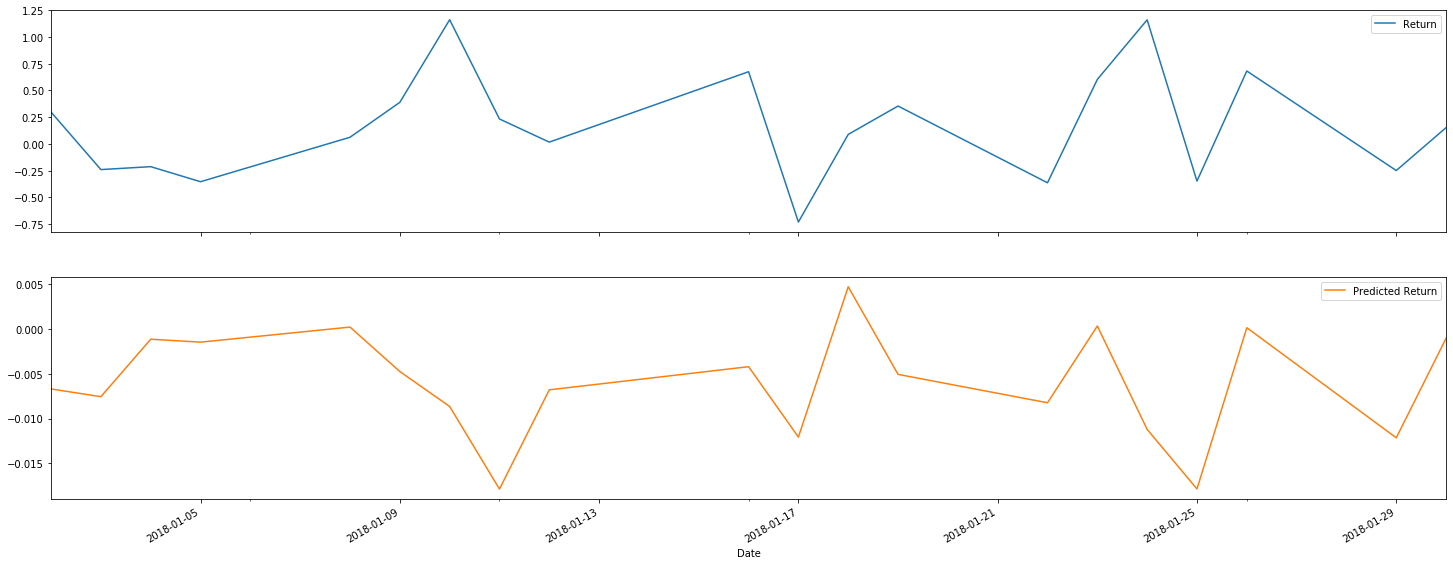

In [42]:
# Plot the first 20 predictions vs the true values
model_results[:20].plot(subplots=True, figsize=(25,10))

# Out-of-Sample Performance

Evaluate the model using "out-of-sample" data (X_test and y_test)

In [48]:
from sklearn.metrics import mean_squared_error
# Calculate the mean_squared_error (MSE) on actual versus predicted test "y" 
mse = mean_squared_error(model_results["Return"], model_results["Predicted Return"])
print(f"Mean Squared Error: {mse}")
# Using that mean-squared-error, calculate the root-mean-squared error (RMSE):
out_of_sample_rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {out_of_sample_rmse}")

Mean Squared Error: 0.17238552644349286
Root Mean Squared Error: 0.4151933603075715


# In-Sample Performance

Evaluate the model using in-sample data (X_train and y_train)

In [53]:
# Construct a dataframe using just the "y" training data:
insample = y_train.to_frame()

# Add a column of "in-sample" predictions to that dataframe:  
X_predict = sklearn_model.predict(X_train)
insample["In-Sample Predictions"] = X_predict

# Calculate in-sample mean_squared_error (for comparison to out-of-sample)
in_mse = mean_squared_error(insample["Return"], insample["In-Sample Predictions"])
print(f"In-Sample Mean Squared Error: {in_mse}")
# Calculate in-sample root mean_squared_error (for comparison to out-of-sample)
in_rmse = np.sqrt(in_mse)
print(f"In-Sample Root Mean Squared Error: {in_rmse}")

In-Sample Mean Squared Error: 0.32008015896905967
In-Sample Root Mean Squared Error: 0.5657562717010388


# Conclusions

YOUR CONCLUSIONS HERE!